### Rainfall Comparison between Seattle and New York City from 2018-01-01 to 2022-12-31
This notebook analyzes whether Seattle experiences more rainfall than New York City using past weather records. 

We will focus on:
1. How often it rains (number of rainy days)
2. Rain patterns throughout the year (monthly average precipitation)


### Data Source

The weather data used in this analysis comes from NOAA Climate Data ([https://www.ncei.noaa.gov/cdo-web/search?datasetid=GHCND - ]).  
It contains daily precipitation records for Seattle, WA, and New York City, NY from January 1, 2018, to December 31, 2022.  

Key columns:
- `date`: The date of the observation
- `precipitation`: Daily rainfall in inches

### Data Cleaning and Preparation

#### 1. Load Libraries and Datasets
Purpose: Import necessary Python libraries and load the Seattle and New York City weather datasets.

In [566]:
# load libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

#load datasets
seattle_rain = pd.read_csv("../data/seattle_rain.csv")
ny_rain = pd.read_csv("../data/ny_rain.csv")


#### 2. Inspect and Clean Data
Purpose: Inspect datasets for structure, convert date columns to datetime, rename precipitation columns, remove duplicates, and filter for the analysis period.

In [567]:
# Inspect dataset
seattle_rain.head()
seattle_rain.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1658 entries, 0 to 1657
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   STATION  1658 non-null   object 
 1   NAME     1658 non-null   object 
 2   DATE     1658 non-null   object 
 3   DAPR     23 non-null     float64
 4   MDPR     23 non-null     float64
 5   PRCP     1636 non-null   float64
 6   SNOW     353 non-null    float64
 7   SNWD     66 non-null     float64
 8   WESD     15 non-null     float64
 9   WESF     28 non-null     float64
dtypes: float64(7), object(3)
memory usage: 129.7+ KB


In [568]:
ny_rain.head()
ny_rain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1743 entries, 0 to 1742
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   STATION  1743 non-null   object 
 1   NAME     1743 non-null   object 
 2   DATE     1743 non-null   object 
 3   DAPR     16 non-null     float64
 4   MDPR     16 non-null     float64
 5   PRCP     1727 non-null   float64
 6   SNOW     410 non-null    float64
dtypes: float64(4), object(3)
memory usage: 95.4+ KB


In [569]:
# Convert date column
seattle_rain['DATE'] = pd.to_datetime(seattle_rain['DATE'],format='%m/%d/%y')
ny_rain['DATE'] = pd.to_datetime(ny_rain['DATE'],format='%Y-%m-%d')


# Rename precipitation column
seattle_rain = seattle_rain.rename(columns={'PRCP': 'precipitation'})
ny_rain = ny_rain.rename(columns={'PRCP': 'precipitation'}) 


In [570]:
# remove unnecessary columns 
seattle_rain = seattle_rain[['DATE','precipitation']]
ny_rain = ny_rain[['DATE','precipitation']]

# remove duplicates
seattle_rain = seattle_rain.drop_duplicates()
ny_rain = ny_rain.drop_duplicates()

# Filter dates from 2018-01-01 to 2022-12-31
seattle_rain = seattle_rain[(seattle_rain['DATE'] >= '2018-01-01') & (seattle_rain['DATE'] <= '2022-12-31')]
ny_rain = ny_rain[(ny_rain['DATE'] >= '2018-01-01') & (ny_rain['DATE'] <= '2022-12-31')]


The datasets are now filtered for the period 2018-2022, with proper column names and no duplicate entries.

#### 3. Handle Missing Values
Purpose: Check for and remove rows with missing precipitation values.

In [571]:
# Identify missing values
print(seattle_rain.isna().sum())
print(ny_rain.isna().sum())

# Remove rows with missing precipitation values
seattle_rain = seattle_rain.dropna(subset=['precipitation'])
ny_rain = ny_rain.dropna(subset=['precipitation'])

DATE              0
precipitation    22
dtype: int64
DATE              0
precipitation    16
dtype: int64


Both datasets now have complete precipitation data and are ready for merging.

#### 4. Combine Datasets
purpose: Merge Seattle and New York datasets, create long-format dataframe, and rename columns for clarity.

In [572]:
# Merge datasets on DATE
rain = pd.merge(seattle_rain, ny_rain, on='DATE', how='inner')

# Create long-format dataframe
rain_long = rain.melt(id_vars='DATE', 
                      value_vars=['precipitation_x','precipitation_y'], 
                      var_name='city', 
                      value_name='precipitation')
rain_long['city'] = rain_long['city'].replace({'precipitation_x':'Seattle','precipitation_y':'New York City'})

# rename columns to lowercase and snake case
rain = rain.rename(columns={'DATE':'date','precipitation_x':'precipitation_seattle','precipitation_y':'precipitation_newyork'})

# create derived variables
rain['rainy_day_seattle'] = rain['precipitation_seattle'] > 0
rain['rainy_day_ny'] = rain['precipitation_newyork'] > 0
rain['month'] = rain['date'].dt.month

The dataframe now has both wide and long formats, with derived variables indicating rainy days and the month for each observation.

###  Data Visualization
#### 1. Total Rainy Days
purpose: Calculate total number of rainy days in each city and visualize using a bar plot.

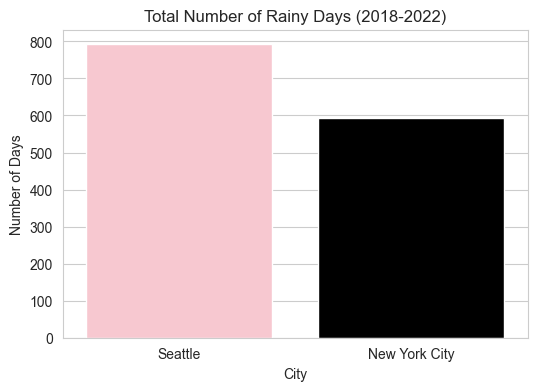

In [573]:
# Total number of rainy days in each city
rainy_days = {
    'Seattle': rain['rainy_day_seattle'].sum(),
    'New York City': rain['rainy_day_ny'].sum()
}

rainy_days_df = pd.DataFrame(list(rainy_days.items()), columns=['City','Rainy Days'])

# Plotting
plt.figure(figsize=(6,4))
sns.barplot(data=rainy_days_df, x='City', y='Rainy Days',hue='City', palette=['pink', 'black'])
plt.title("Total Number of Rainy Days (2018-2022)")
plt.ylabel("Number of Days")
plt.show()


Interpretation: Seattle has more rainy days than New York City between 2018 and 2022, indicating that rainfall occurs more frequently in Seattle even if the total amount of rain isn’t always higher.

#### 2. Monthly Average Precipitation
Purpose: Calculate average monthly precipitation for each city and visualize seasonal patterns.

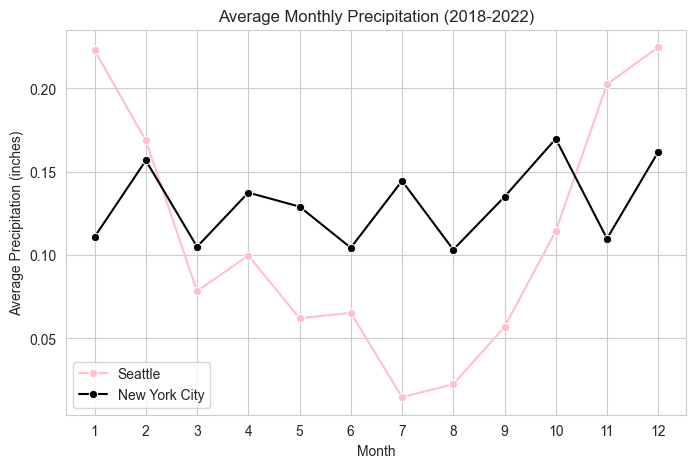

In [574]:
# Monthly average Precipitation
monthly_avg = rain.groupby('month')[['precipitation_seattle','precipitation_newyork']].mean().reset_index()

# Plotting
plt.figure(figsize=(8,5))
sns.lineplot(data=monthly_avg, x='month', y='precipitation_seattle', label='Seattle', marker='o', color='pink')
sns.lineplot(data=monthly_avg, x='month', y='precipitation_newyork', label='New York City', marker='o', color='black')
plt.title("Average Monthly Precipitation (2018-2022)")
plt.xlabel("Month")
plt.ylabel("Average Precipitation (inches)")
plt.xticks(range(1,13))
plt.show()

Interpretation: Seattle experiences heavier rainfall during winter and drier summers, while New York City’s rainfall remains relatively steady throughout the year with only slight seasonal changes.

#### 3. Conclusion 

- Seattle has more rainy days than New York City.  
- Seattle’s rainfall is more seasonal, heavier in winter.  
- New York City’s rainfall is more evenly distributed throughout the year.  
- Overall, Seattle rains more frequently, but total precipitation amount can vary month to month.